# The Capital Asset Pricing Model and Arbitrage Pricing Theory

by Beha Abasi, Maxwell Margenot, and Delaney Granizo-Mackenzie

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [https://github.com/quantopian/research_public](https://github.com/quantopian/research_public)


---

The Capital Asset Pricing Model (CAPM) is a classic measure of the cost of capital. It is used often in finance to evaluate the price of assets and to assess the impact of the risk premium from the market at large. In this lecture, we discuss the CAPM the more general Arbitrage Pricing Theory (APT) to form a basis for evaluating the risk associated with various factors.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels import regression
import matplotlib.pyplot as plt

## Idiosyncratic and Systematic Risk

In general, portfolios and assets can face two types of risk: idiosyncratic and systematic risk. **Idiosyncratic risk** refers to risks that are firm-specific and can be diversified away, such as a management change or a faulty production, while **systematic risk** is market-wide and affects all market participants. An example could be a slowing of the economy or a change in the interest rate. Because all firms are exposed to systematic risk, it cannot be diversified away.

## Risk Premia

As the number of assets in a portfolio increases, many of the idiosyncratic risks cancel out and are diversified away. This is the key reason why we want to avoid [position concentration risk](https://www.quantopian.com/lectures/position-concentration-risk). As your portfolio grows larger and makes more independent bets through diversification, the variance of the portfolio declines until only the systematic risk remains. As we cannot remove systematic risk, investors must be given a risk premium above the rate of risk-free return to compensate them for the risk they take on by investing in this portfolio. The individual firm-level risks in this portfolio do not have associated premia as this would create arbitrage opportunities. Shareholders could collect the risk premium while diversifying away the risk associated with them. That would mean additional profit without any additional exposure. This is the definition of an arbitrage opportunity!

From this reasoning we can conclude that the premium on an asset should have no relation to its idiosyncratic risk, but should instead rely solely on the level of systematic risk it carries. In order to accurately compute the risk premium of an asset, and consequently our expected return, we need to find a measure of systematic risk. If we have that, then we can theoretically define the return of an asset in the following way:

$$E[\mbox{Return}] = \mbox{Risk-Free Rate of Return} + \mbox{Risk Premium}$$

One way to do this is to estimate how changes in the excess return of an asset are related to changes in the excess return of the market. Expressing this as a linear regression gives us the relationship as the change in expected return of an asset for each 1% change in the return of the market portfolio.

In theory, this market portfolio should have no diversifiable risk left and would therefore only fluctuate with systematic shocks. In practice, we use a market index such as the S&P500 as a proxy for the market portfolio. The beta that we get from regressing an asset's returns on the returns of the market will be our measure of systematic risk. This beta represents the sensitivity of an asset's return stream to market-wide shocks.

Given this beta, the risk premium of asset $i$ is defined as:

$$\mbox{Risk Premium of Asset}_i = \beta (\mbox{Market Risk Premium})$$

We call this simplistic model the Capital Asset Pricing Model (CAPM).

## Capital Asset Pricing Theory

We can express the CAPM more clearly like so:

$$E[R_i] = R_F + \beta(E[R_M] - R_F)$$

where $R_i$ is the return of asset $i$, $R_F$ is the risk-free rate, and $R_M$ is the return of the market. The CAPM is one of the most basic measures of the cost of capital. It determines the minimum return required to entice investors to hold a certain asset.

To put it another way, CAPM says that the return of an asset should be the risk-free rate, which is what we would demand to account for inflation and the time value of money, as well as something extra to compensate us for the amount of systematic risk we are exposed to.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     59.35
Date:                Mon, 28 Aug 2017   Prob (F-statistic):           3.12e-13
Time:                        19:11:42   Log-Likelihood:                 749.29
No. Observations:                 251   AIC:                            -1495.
Df Residuals:                     249   BIC:                            -1488.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const                  0.0010      0.001      1.331      0.185        -0.000     0.003
Equity(8554 [SPY])     0.8438      0.110      7.704      0.000         0.628     1.059
==============================================================================
Omnibus:                       74.662   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2468.684
Skew:                          -0.320   Prob(JB):                         0.00
Kurtosis:                      18.351   Cond. No.                         141.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

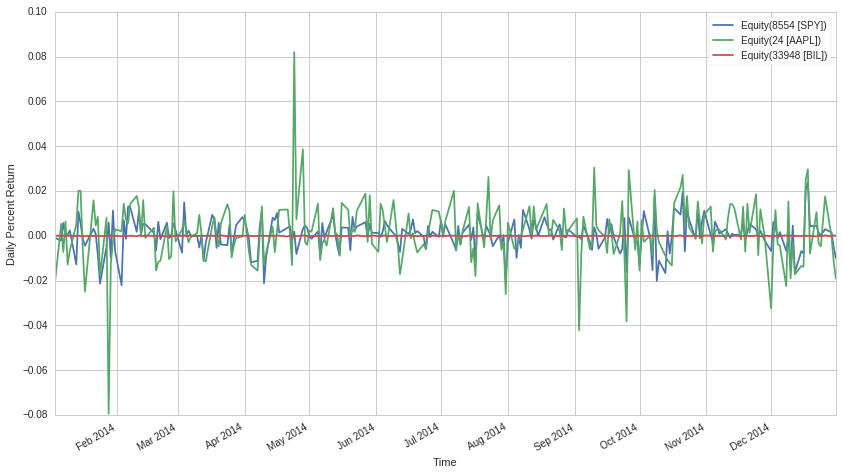

In [2]:
start_date = '2014-01-01'
end_date = '2014-12-31'

# choose stock
R = get_pricing('AAPL', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]

# risk-free proxy
R_F = get_pricing('BIL', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]

# find it's beta against market
M = get_pricing('SPY', start_date=start_date, end_date=end_date, fields='price').pct_change()[1:]

AAPL_results = regression.linear_model.OLS(R-R_F, sm.add_constant(M)).fit()
AAPL_beta = AAPL_results.params[1]

M.plot()
R.plot()
R_F.plot()
plt.xlabel('Time')
plt.ylabel('Daily Percent Return')
plt.legend();

AAPL_results.summary()

We can then use our calculated beta exposure to make predictions of returns.

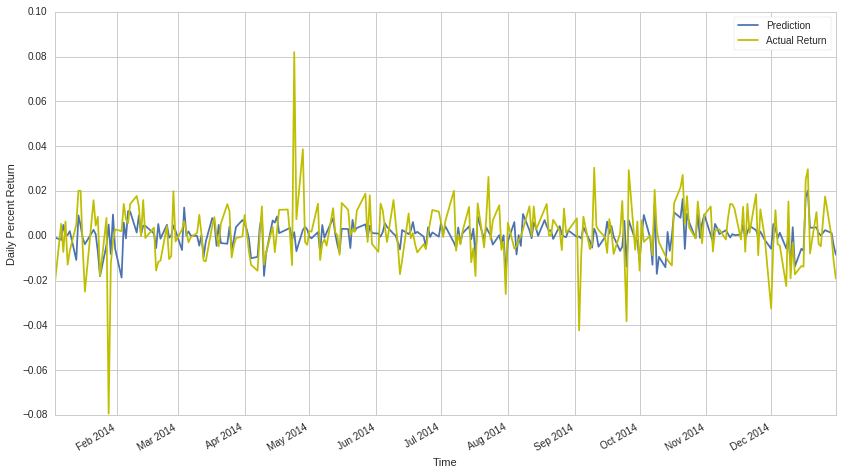

In [3]:
predictions = R_F + AAPL_beta*(M - R_F) # CAPM equation

predictions.plot()
R.plot(color='Y')
plt.legend(['Prediction', 'Actual Return'])

plt.xlabel('Time')
plt.ylabel('Daily Percent Return');

## CAPM Assumptions

In our derivation of the CAPM, we made two main assumptions:
* We assumed that investors are able to trade without delay or cost and that everyone is able to borrow or lend money at the risk free rate.
* We assumed that all investors are "mean-variance optimizers". What this essentially means is that they would only demand portfolios that have the highest return attainable for a given level of risk. These portfolios are all found along the **efficient frontier**.

The following is a programmatic derivation of the efficient frontier for portfolios of four assets.

In [4]:
from scipy import optimize
import cvxopt as opt
from cvxopt import blas, solvers

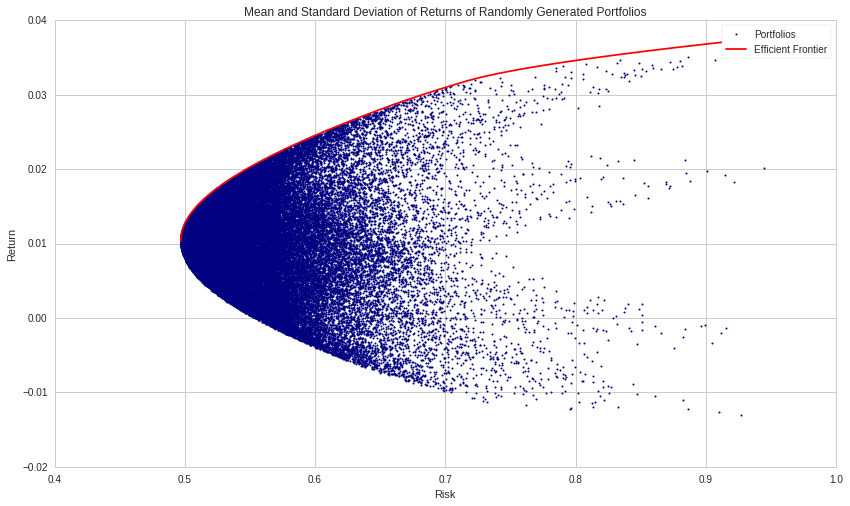

In [5]:
np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False

# Number of assets
n_assets = 4

# Number of observations
n_obs = 2000

## Generating random returns for our 4 securities
return_vec = np.random.randn(n_assets, n_obs)

def rand_weights(n):
    ''' 
    Produces n random weights that sum to 1 
    '''
    k = np.random.rand(n)
    return k / sum(k)

def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

def optimal_portfolios(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100000
    
    # Creating a list of returns to optimize the risk for
    mus = [100**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    
    ## Calculate the risk and returns of the frontier
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    
    return returns, risks

n_portfolios = 50000

means, stds = np.column_stack([random_portfolio(return_vec) for x in range(n_portfolios)])

returns, risks = optimal_portfolios(return_vec)

plt.plot(stds, means, 'o', markersize=2, color='navy')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.title('Mean and Standard Deviation of Returns of Randomly Generated Portfolios');

plt.plot(risks, returns, '-', markersize=3, color='red');
plt.legend(['Portfolios', 'Efficient Frontier']);

Each blue dot represents a different portfolio, while the red line skimming the outside of the cloud is the efficient frontier. The efficient frontier contains all portfolios that are the best for a given level of risk.

The optimal, or most efficient, portfolio on this line is found by maximizing the Sharpe ratio, the ratio of excess return and volatility. We use this to determine the portfolio with the best risk-to-reward tradeoff.

The line that represents the different combinations of a risk-free asset with a portfolio of risky assets is known as the Capital Allocations Line (CAL). The slope of the CAL is the Sharpe ratio. To maximize the Sharpe ratio, we need to find the steepest CAL, which coincides with the CAL that is tangential to the efficient frontier. This is why the efficient portfolio is sometimes referred to as the tangent portfolio.

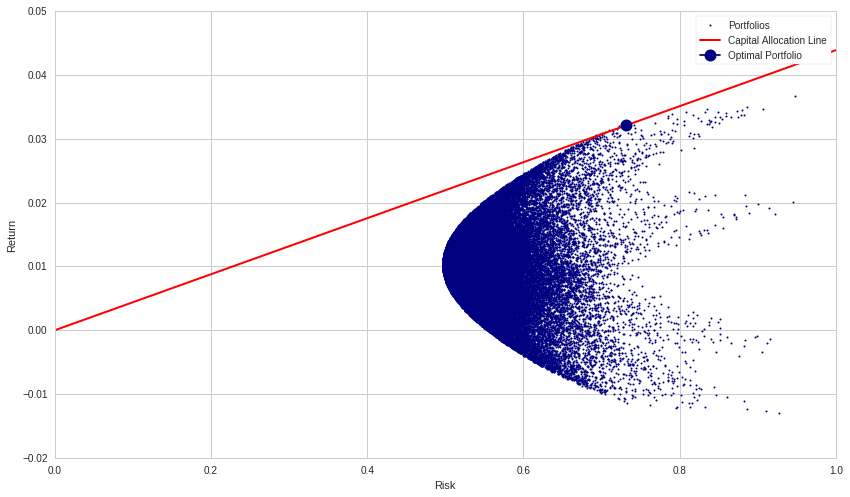

In [6]:
def maximize_sharpe_ratio(return_vec, risk_free_rate):
    """
    Finds the CAPM optimal portfolio from the efficient frontier 
    by optimizing the Sharpe ratio.
    """
    
    def find_sharpe(weights):
        
        means = [np.mean(asset) for asset in return_vec]
        
        numerator = sum(weights[m]*means[m] for m in range(len(means))) - risk_free_rate
        
        weight = np.array(weights)
        
        denominator = np.sqrt(weights.T.dot(np.corrcoef(return_vec).dot(weights)))
        
        return numerator/denominator
    
    guess = np.ones(len(return_vec)) / len(return_vec)
    
    def objective(weights):
        return -find_sharpe(weights)
    
    # Set up equality constrained
    cons = {'type':'eq', 'fun': lambda x: np.sum(np.abs(x)) - 1} 

    # Set up bounds for individual weights
    bnds = [(0, 1)] * len(return_vec)
    
    results = optimize.minimize(objective, guess,
                            constraints=cons, bounds=bnds, 
                            method='SLSQP', options={'disp': False})
    
    return results

risk_free_rate = np.mean(R_F)

results = maximize_sharpe_ratio(return_vec, risk_free_rate)

# Applying the optimal weights to each assset to get build portfolio
optimal_mean = sum(results.x[i]*np.mean(return_vec[i]) for i in range(len(results.x)))

optimal_std = np.sqrt(results.x.T.dot(np.corrcoef(return_vec).dot(results.x)))

# Plot of all possible portfolios
plt.plot(stds, means, 'o', markersize=2, color='navy')
plt.ylabel('Return')
plt.xlabel('Risk')

# Line from the risk-free rate to the optimal portfolio
eqn_of_the_line = lambda x : ( (optimal_mean-risk_free_rate) / optimal_std ) * x + risk_free_rate    

xrange = np.linspace(0., 1., num=11)

plt.plot(xrange, [eqn_of_the_line(x) for x in xrange], color='red', linestyle='-', linewidth=2)

# Our optimal portfolio
plt.plot([optimal_std], [optimal_mean], marker='o', markersize=12, color="navy")

plt.legend(['Portfolios', 'Capital Allocation Line', 'Optimal Portfolio']);

We can look at the returns and risk of the individual assets compared to the optimal portfolio we found to easily showcase the power of diversification.

In [7]:
for a in range(len(return_vec)): 
    print "Return and Risk of Asset", a, ":", np.mean(return_vec[a]), ",",np.std(return_vec[a])   
    
print "Return and Risk of Optimal Portfolio", optimal_mean, optimal_std

Return and Risk of Asset 0 : -0.0155874843425 , 0.979925446819
Return and Risk of Asset 1 : 0.0384158887148 , 0.985658403299
Return and Risk of Asset 2 : 0.0206467377992 , 0.991949738581
Return and Risk of Asset 3 : -0.00443686547651 , 1.00311968218
Return and Risk of Optimal Portfolio 0.0321127409574 0.73112973553


# Capital Market Line is CAL through market portfolio

Our optimal portfolio has a decently high return as well as less risk than any individual asset, as expected. Theoeretically, all investors should demand this optimal, tangent portfolio. If we accumulate the portfolios of all investors, we end up with the market portfolio, since all shares must be held by someone. This means that the tangency portfolio is the market portfolio, essentially saying that demand must equal supply.

When a risk-free asset is added to the portfolio, the Capital Asset Line turns into the Capital Market Line (CML). According to the CAPM, any stock or portfolio that lies to the right of CML would contain diversifiable risk and is therefore not efficient.

The mapping of each security's beta to its expected return results in the Security Markets Line. The difference between a security's return and the expected return as predicted by CAPM is known as the alpha.

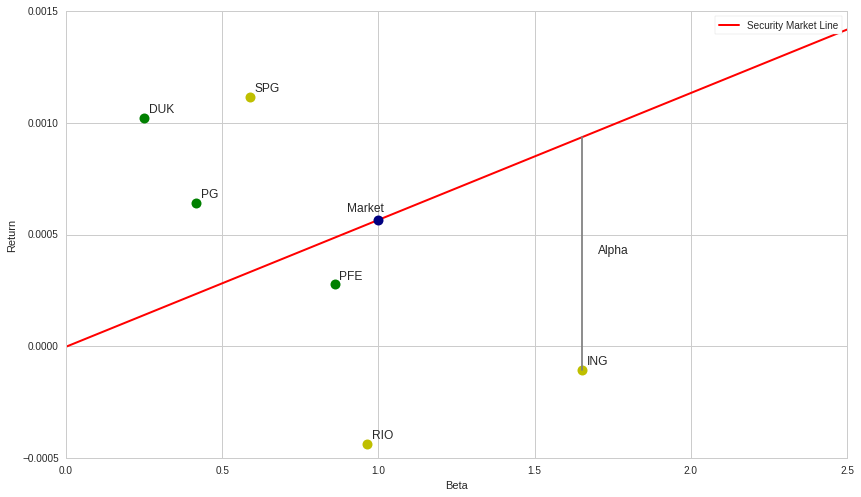

In [8]:
risk_free_rate = np.mean(R_F)

# We have two coordinates that we use to map the SML: (0, risk-free rate) and (1, market return)

eqn_of_the_line = lambda x : ( (np.mean(M)-risk_free_rate) / 1.0) * x + risk_free_rate        
xrange = np.linspace(0., 2.5, num=2)
plt.plot(xrange, [eqn_of_the_line(x) for x in xrange], color='red', linestyle='-', linewidth=2)

plt.plot([1], [np.mean(M)], marker='o', color='navy', markersize=10)
plt.annotate('Market', xy=(1, np.mean(M)), xytext=(0.9, np.mean(M)+0.00004))

# Next, we will compare to see whether stocks in more cyclical industries have higher betas
# Of course, a more thorough analysis is required to rigorously answer this question

# Non-Cyclical Industry Stocks
non_cyclical = ['PG', 'DUK', 'PFE']
non_cyclical_returns = get_pricing(
    non_cyclical,
    fields='price',
    start_date=start_date,
    end_date=end_date
).pct_change()[1:]
non_cyclical_returns.columns = map(lambda x: x.symbol, non_cyclical_returns.columns)

non_cyclical_betas = [
    regression.linear_model.OLS(
        non_cyclical_returns[asset],
        sm.add_constant(M)
    ).fit().params[1]
     for asset in non_cyclical
]

for asset, beta in zip(non_cyclical, non_cyclical_betas):
    plt.plot([beta], [np.mean(non_cyclical_returns[asset])], marker='o', color='g', markersize=10)
    plt.annotate(
        asset,
        xy=(beta, np.mean(non_cyclical_returns[asset])),
        xytext=(beta + 0.015, np.mean(non_cyclical_returns[asset]) + 0.000025)
    )

# Cyclical Industry Stocks
cyclical = ['RIO', 'SPG', 'ING']
cyclical_returns = get_pricing(
    cyclical,
    fields='price',
    start_date=start_date,
    end_date=end_date
).pct_change()[1:]
cyclical_returns.columns = map(lambda x: x.symbol, cyclical_returns.columns)

cyclical_betas = [
    regression.linear_model.OLS(
        cyclical_returns[asset],
        sm.add_constant(M)
    ).fit().params[1]
     for asset in cyclical
]

for asset, beta in zip(cyclical, cyclical_betas):
    plt.plot([beta], [np.mean(cyclical_returns[asset])], marker='o', color='y', markersize=10)
    plt.annotate(
        asset,
        xy=(beta, np.mean(cyclical_returns[asset])),
        xytext=(beta + 0.015, np.mean(cyclical_returns[asset]) + 0.000025)
    )

# drawing the alpha, which is the difference between expected return and the actual return
plt.plot(
    [cyclical_betas[2], cyclical_betas[2]],
    [np.mean(cyclical_returns.iloc[:, 2]), eqn_of_the_line(cyclical_betas[2])],
    color='grey'
)
plt.annotate(
    'Alpha',
    xy=(
        cyclical_betas[2] + 0.05,
        (eqn_of_the_line(cyclical_betas[2])-np.mean(cyclical_returns.iloc[:,2]))/2+np.mean(cyclical_returns.iloc[:,2])
    ),
    xytext=(
        cyclical_betas[2] + 0.05,
        (eqn_of_the_line(cyclical_betas[2])-np.mean(cyclical_returns.iloc[:,2]))/2+np.mean(cyclical_returns.iloc[:,2])
    )
)

plt.xlabel("Beta")
plt.ylabel("Return")

plt.legend(['Security Market Line']);

For more details on the CAPM, check out the [wikipedia page](https://en.wikipedia.org/wiki/Capital_asset_pricing_model).

# Arbitrage Pricing Theory

The CAPM, while widely used and studied, has many drawbacks. With strict, limiting assumptions, it does not hold up well in empirical tests. Arbitrage Pricing Theory (APT) aims to generalize the CAPM model, as assets may be exposed to classes of risks other than the market risk and investors may care about things other than just the mean and variance.

APT is a major asset pricing theory that relies on expressing the returns using a linear factor model:

$$R_i = a_i + b_{i1} F_1 + b_{i2} F_2 + \ldots + b_{iK} F_K + \epsilon_i$$

A factor is a return stream that is determined completely by some characteristic. For example, the CAPM has only one factor, market return. If we have modelled our rate of return as above, then the expected returns should take the form of:

$$ E(R_i) = R_F + b_{i1} \lambda_1 + b_{i2} \lambda_2 + \ldots + b_{iK} \lambda_K $$

where $R_F$ is the risk-free rate, and $\lambda_j$ is the risk premium - the return in excess of the risk-free rate - for factor $j$. This premium arises because investors require higher returns to compensate them for incurring higher risk.

We'll compute the risk premia for our factors with Fama-Macbeth regression. However, there are various ways to compute each $\lambda_j$!

## Arbitrage

Now that we have a reasonably general way to compute expected return, we can discuss arbitrage more technically. There are generally many, many securities in our universe. If we use different ones to compute the $\{\lambda_i\}$, will our results be consistent? If our results are inconsistent, there is an *arbitrage opportunity* (in expectation), an operation that earns a profit without incurring risk and with no net investment of money. In this case, we mean that there is a risk-free operation with *expected* positive return that requires no net investment. It occurs when expectations of returns are inconsistent, i.e. risk is not priced consistently across securities.

Say that there is an asset with expected rate of return 0.2 for the next year and a $\beta$ of 1.2 with the market, while the market is expected to have a rate of return of 0.1, and the risk-free rate on 1-year bonds is 0.05. Then the APT model tells us that the expected rate of return on the asset should be

$$ R_F + \beta \lambda = 0.05 + 1.2 (0.1 - 0.05) = 0.11$$

This does not agree with the prediction that the asset will have a rate of return of 0.2. So, if we buy \$100 of our asset, short \$120 of the market, and buy \$20 of bonds, we will have invested no net money and are not exposed to any systematic risk (we are market-neutral), but we expect to earn $0.2(100) - 0.1(120) + 0.05(20) = 9$ dollars at the end of the year.

The APT assumes that these opportunities will be taken advantage of until prices shift and the arbitrage opportunities disappear. That is, it assumes that there are arbitrageurs who have sufficient amounts of patience and capital. This provides a justification for the use of empirical factor models in pricing securities: if the model was inconsistent, there would be an arbitrage opportunity, and so the prices would adjust.

## Goes Both Ways

Accurately knowing $E(R_i)$ is incredibly difficult, but this model tells us what the expected returns should be if the market is free of arbitrage. This lays the groundwork for strategies based on factor model ranking systems. If you have a model for the expected return of an asset, then you can rank those assets based on their expected performance and use this information to make trades. This creation of a ranking scheme is the hallmark of a [long-short equity strategy](https://www.quantopian.com/lectures/long-short-equity)

## Testing Arbitrage Pricing Theory

Most empirical tests of the APT are done in two steps: estimating the betas of individual factors, then comparing it to actual prices to see how predictions fared.

Here we will use the return streams from long-short equity strategies built from various microeconomic indicators as our factors. Then, we will use the Fama-Macbeth regression method to estimate our risk premia.

In [9]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.factors import Returns, Latest
from quantopian.pipeline.filters import Q1500US
from quantopian.research import run_pipeline
from quantopian.pipeline.classifiers.fundamentals import Sector
import itertools

Now we use pipeline to get all of our data.

In [10]:
def make_pipeline():
    
    pipe = Pipeline()

    # Add our factors to the pipeline
    purchase_of_biz = Latest([Fundamentals.purchase_of_business])
    pipe.add(purchase_of_biz, 'purchase_of_business')
    
    RD = Latest([Fundamentals.research_and_development])
    pipe.add(RD, 'RD')
    
    operating_cash_flow = Latest([Fundamentals.operating_cash_flow])
    pipe.add(operating_cash_flow, 'operating_cash_flow')
    
    # Create factor rankings and add to pipeline
    purchase_of_biz_rank = purchase_of_biz.rank()
    RD_rank = RD.rank()
    operating_cash_flow_rank = operating_cash_flow.rank()

    pipe.add(purchase_of_biz_rank, 'purchase_of_biz_rank')
    pipe.add(RD_rank, 'RD_rank')
    pipe.add(operating_cash_flow_rank, 'operating_cash_flow_rank')
    
    most_biz_bought = purchase_of_biz_rank.top(1000)
    least_biz_bought = purchase_of_biz_rank.bottom(1000)
    
    most_RD = RD_rank.top(1000)
    least_RD = RD_rank.bottom(1000)
    
    most_cash = operating_cash_flow_rank.top(1000)
    least_cash = operating_cash_flow_rank.bottom(1000)
    
    pipe.add(most_biz_bought, 'most_biz_bought')
    pipe.add(least_biz_bought, 'least_biz_bought')
    
    pipe.add(most_RD, 'most_RD')
    pipe.add(least_RD, 'least_RD')
    
    pipe.add(most_cash, 'most_cash')
    pipe.add(least_cash, 'least_cash')
    
    # We also get daily returns
    returns = Returns(window_length=2)
    
    # and sector types
    sectors = Sector()

    pipe.add(returns, "Returns")
    
    # We will focus on technology stocks in the Q1500
    pipe.set_screen(
        (Q1500US() & sectors.eq(311)) & 
        most_biz_bought | least_biz_bought | 
        most_RD | least_RD |
        most_cash | least_cash
    )
    
    return pipe

pipe = make_pipeline()
results = run_pipeline(pipe, start_date, end_date)

results.head()

RD  RD_rank  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])      4.400000e+07   1557.0   
                          Equity(24 [AAPL])     1.168000e+09   1798.0   
                          Equity(25 [ARNC_PR])  4.400000e+07   1558.0   
                          Equity(31 [ABAX])     3.418000e+06    732.0   
                          Equity(52 [ABM])               NaN      NaN   

                                                 Returns least_RD  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])      0.009497    False   
                          Equity(24 [AAPL])     0.012011    False   
                          Equity(25 [ARNC_PR])       NaN    False   
                          Equity(31 [ABAX])    -0.002990     True   
                          Equity(52 [ABM])     -0.007636    False   

                                               least_biz_bought least_cash  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])                False      False   
                          Equity(24 [AAPL])                True      False   
                          Equity(25 [ARNC_PR])            False      False   
                          Equity(31 [ABAX])               False      False   
                          Equity(52 [ABM])                 True      False   

                                               most_RD most_biz_bought  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])        True           False   
                          Equity(24 [AAPL])       True           False   
                          Equity(25 [ARNC_PR])    True           False   
                          Equity(31 [ABAX])      False           False   
                          Equity(52 [ABM])       False           False   

                                               most_cash  operating_cash_flow  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])          True         2.140000e+08   
                          Equity(24 [AAPL])         True         9.908000e+09   
                          Equity(25 [ARNC_PR])      True         2.140000e+08   
                          Equity(31 [ABAX])        False         2.019000e+06   
                          Equity(52 [ABM])         False         5.101200e+07   

                                                operating_cash_flow_rank  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])                        4408.0   
                          Equity(24 [AAPL])                       5130.0   
                          Equity(25 [ARNC_PR])                    4409.0   
                          Equity(31 [ABAX])                       1576.0   
                          Equity(52 [ABM])                        3480.0   

                                                purchase_of_biz_rank  \
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])                    1178.0   
                          Equity(24 [AAPL])                    308.0   
                          Equity(25 [ARNC_PR])                1180.0   
                          Equity(31 [ABAX])                      NaN   
                          Equity(52 [ABM])                     643.0   

                                                purchase_of_business  
2014-01-02 00:00:00+00:00 Equity(2 [ARNC])                       0.0  
                          Equity(24 [AAPL])              -53000000.0  
                          Equity(25 [ARNC_PR])                   0.0  
                          Equity(31 [ABAX])                      NaN  
                          Equity(52 [ABM])                -7982000.0

To get our factor return streams, we rank equities based on their purchases of businesses, their R&D spending, and their cash flow. Then, for each indicator, we go long the assets in the top percentile and short the ones in the bottom. 

In [11]:
most_biz_bought = results[results.most_biz_bought]['Returns'].groupby(level=0).mean()
least_biz_bought = results[results.least_biz_bought]['Returns'].groupby(level=0).mean()

most_RD = results[results.most_RD]['Returns'].groupby(level=0).mean()
least_RD = results[results.least_RD]['Returns'].groupby(level=0).mean()

most_cash = results[results.most_cash]['Returns'].groupby(level=0).mean()
least_cash = results[results.least_cash]['Returns'].groupby(level=0).mean()

# Calculating our factor return streams
biz_purchase_portfolio = most_biz_bought - least_biz_bought
RD_portfolio = most_RD - least_RD
cash_flow_portfolio = most_cash - least_cash

Finally, we'll put everything together in our Fama-Macbeth regressions. This occurs in two steps.

First, for each asset we regress its returns on each factor return stream:

$$R_{1, t} = \alpha_1 + \beta_{1, F_1}F_{1, t} + \beta_{1, F_2}F_{2, t} + \dots + \beta_{1, F_m}F_{m, t} + \epsilon_{1, t} \\
R_{2, t} = \alpha_2 + \beta_{2, F_1}F_{1, t} + \beta_{2, F_2}F_{2, t} + \dots + \beta_{2, F_m}F_{m, t} + \epsilon_{2, t} \\
\vdots \\
R_{n, t} = \alpha_n + \beta_{n, F_1}F_{1, t} + \beta_{n, F_2}F_{2, t} + \dots + \beta_{n, F_m}F_{m, t} + \epsilon_{n, t}$$

Second, we take the beta estimates from the first step and use those as our exogenous variables in an estimate of the mean return of each asset. This step is the calculation of our risk premia, $\{\gamma_K\}$.

$$E(R_i) = \gamma_0 + \gamma_1 \hat{\beta}_{i, F_1} + \gamma_2 \hat{\beta}_{i, F_2} + \dots + \gamma_m \hat{\beta}_{i, F_m} + \epsilon_i$$

In [12]:
# putting all of our data from pipeline into a DataFrame for convenience
# we'll have to first do some data manipulating since our factor return streams are date specific,
# but our asset returns are both date and asset specific

data = results[['Returns']].set_index(results.index)
asset_list_sizes = [group[1].size for group in data.groupby(level=0)]

purchase_of_biz_column = [
    [biz_purchase_portfolio.loc[group[0]]] * size
     for group, size in zip(data.groupby(level=0), asset_list_sizes)
]
data['Purchase of Business'] = list(itertools.chain(*purchase_of_biz_column))

RD_column = [
    [RD_portfolio.loc[group[0]]] * size
     for group, size in zip(data.groupby(level=0), asset_list_sizes)
]
data['RD'] = list(itertools.chain(*RD_column))

cash_flow_column = [
    [cash_flow_portfolio.loc[group[0]]] * size
     for group, size in zip(data.groupby(level=0), asset_list_sizes)
]
data['Operating Cash Flow'] = list(itertools.chain(*cash_flow_column))

data = sm.add_constant(data.dropna())

# Our list of assets from pipeline
assets = data.index.levels[1].unique()

X = [data.xs(asset, level=1)['Returns'] for asset in assets] 
Y = [
    data.xs(asset, level=1)[['Purchase of Business', 'RD', 'Operating Cash Flow', 'const']]
     for asset in assets
]

# First regression step: estimating the betas
reg_results = [
    regression.linear_model.OLS(x-risk_free_rate, y).fit().params
     for x, y in zip(X, Y) if not(x.empty or y.empty)
]
indices = [asset for x, y, asset in zip(X, Y, assets) if not(x.empty or y.empty)]

betas = pd.DataFrame(reg_results, index=indices)
betas = sm.add_constant(betas.drop('const', axis=1))

R = data['Returns'].mean(axis=0, level=1)

# Second regression step: estimating the risk premia
final_results = regression.linear_model.OLS(R - risk_free_rate, betas).fit()

final_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     103.9
Date:                Mon, 28 Aug 2017   Prob (F-statistic):           4.90e-65
Time:                        19:13:41   Log-Likelihood:                 18879.
No. Observations:                4453   AIC:                        -3.775e+04
Df Residuals:                    4449   BIC:                        -3.772e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
const                    0.0006   7.26e-05      8.258      0.000         0.000     0.001
Purchase of Business -3.286e-05   2.61e-05     -1.260      0.208      -8.4e-05  1.83e-05
RD                   -9.464e-05   3.02e-05     -3.138      0.002        -0.000 -3.55e-05
Operating Cash Flow      0.0005   5.59e-05      8.203      0.000         0.000     0.001
==============================================================================
Omnibus:                     3269.904   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1499648.807
Skew:                          -2.310   Prob(JB):                         0.00
Kurtosis:                      92.784   Cond. No.                         9.11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It is imperative that we not just use our model estimates at face value. A scan through the accompanying statistics can be highly insightful about the efficacy of our estimated model. For example, notice that although our individual factors are significant, we have a very low $R^2$. What this may suggest is that there is a real link between our factors and the returns of our assets, but that there still remains a lot of unexplained noise!

For a more in-depth look at choosing factors, check out the [factor analysis lecture](https://www.quantopian.com/lectures/factor-analysis)!

In [13]:
# smoke test for multicollinearity
print data[['Purchase of Business', 'RD', 'Operating Cash Flow']].corr()

                      Purchase of Business        RD  Operating Cash Flow
Purchase of Business              1.000000 -0.075791            -0.625021
RD                               -0.075791  1.000000             0.032609
Operating Cash Flow              -0.625021  0.032609             1.000000


Now that we have estimates for our risk premia we can combine these with our beta estimates from our original regression to estimate asset returns.

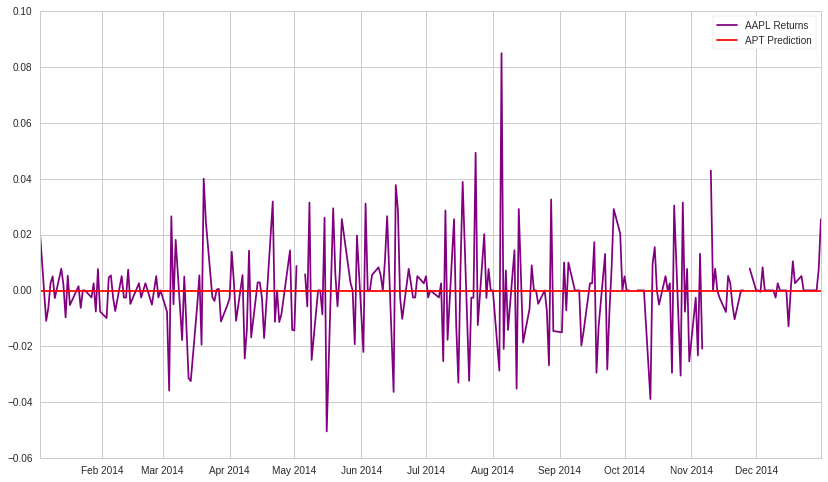

In [14]:
# this is our actual model!
expected_return = risk_free_rate \
    + betas['Purchase of Business']*final_results.params[1] \
    + betas['RD']*final_results.params[2] \
    + betas['Operating Cash Flow']*final_results.params[3]

year_of_returns = get_pricing(
    expected_return.index,
    start_date,
    end_date,
    fields='close_price'
).pct_change()[1:]

plt.plot(year_of_returns[expected_return.index[1]], color='purple')
plt.plot(pd.DataFrame({'Expected Return': expected_return.iloc[0]}, index=year_of_returns.index), color='red')
plt.legend(['AAPL Returns', 'APT Prediction']);

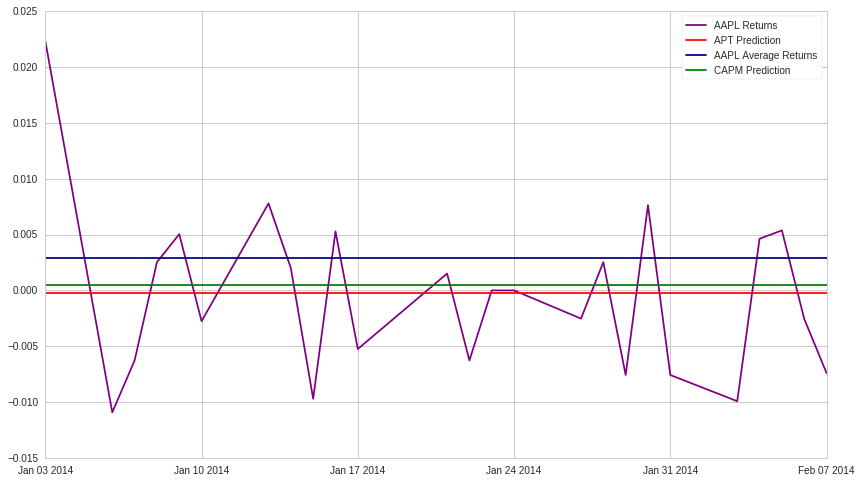

In [15]:
# Compare AAPL prediction of CAPM vs. our APT model
M_annual_return = get_pricing('SPY', start_date=start_date, end_date=end_date, fields='price').pct_change()[1:]

# We'll take the market beta we calculated from the beginning of the lecture
CAPM_AAPL_prediction = risk_free_rate + AAPL_beta*(M_annual_return.mean() - risk_free_rate)

# Let's take a closer look
year_of_returns = year_of_returns[:25]

plt.plot(year_of_returns[expected_return.index[1]], color='purple')
plt.plot(pd.DataFrame({'Expected Return': expected_return.iloc[0]}, index=year_of_returns.index), color='red')
plt.plot(pd.DataFrame({'Expected Return': year_of_returns.mean()[0]}, index=year_of_returns.index), color='navy')
plt.plot(pd.DataFrame({'Expected Return': CAPM_AAPL_prediction}, index=year_of_returns.index), color='green')
plt.legend(['AAPL Returns', 'APT Prediction', 'AAPL Average Returns', 'CAPM Prediction']);\

Finally, as a rough comparison between APT and CAPM, we'll look at the returns from Long-Short strategies constructed using each model as the ranking scheme.

Returns after a year: APT versus CAPM
0.317629468354


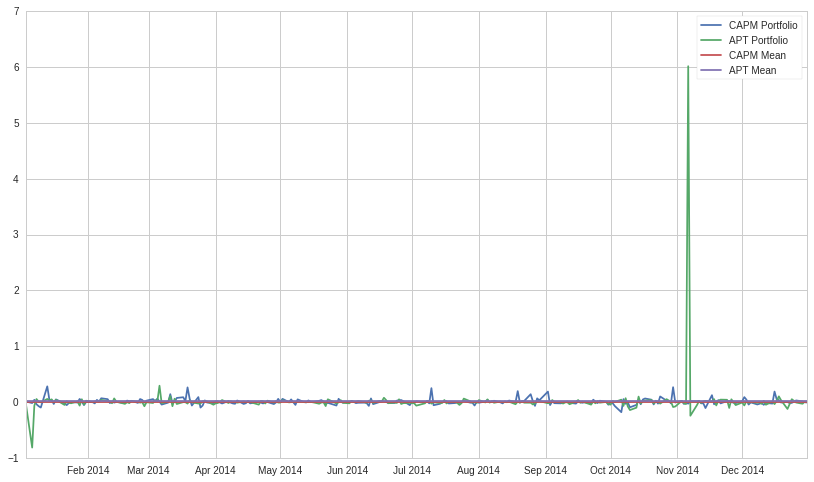

In [16]:
market_betas = [
    regression.linear_model.OLS(x[1:], sm.add_constant(M_annual_return)).fit().params[1]
     for x in X if (x[1:].size == M_annual_return.size)
]
indices = [asset for x, asset in zip(X, assets) if (x[1:].size == M_annual_return.size)]

market_return = pd.DataFrame({'Market': M_annual_return.mean()}, index = indices)

CAPM_predictions = risk_free_rate + market_betas*(market_return['Market'] - risk_free_rate)
CAPM_predictions.sort_values(inplace=True, ascending=False)

CAPM_portfolio = [CAPM_predictions.head(5).index, CAPM_predictions.tail(5).index]
CAPM_long = get_pricing(
    CAPM_portfolio[0],
    start_date=start_date,
    end_date=end_date,
    fields='price'
).pct_change()[1:].mean(axis=1)
CAPM_short = get_pricing(
    CAPM_portfolio[1],
    start_date=start_date,
    end_date=end_date,
    fields='price'
).pct_change()[1:].mean(axis=1)

CAPM_returns = CAPM_long - CAPM_short

expected_return.sort_values(inplace=True, ascending=False)

APT_portfolio = [expected_return.head(5).index, expected_return.tail(5).index]
APT_long = get_pricing(
    APT_portfolio[0],
    start_date=start_date,
    end_date=end_date,
    fields='price'
).pct_change()[1:].mean(axis=1)
APT_short = get_pricing(
    APT_portfolio[1],
    start_date=start_date,
    end_date=end_date,
    fields='price'
).pct_change()[1:].mean(axis=1)

APT_returns = APT_long - APT_short

plt.plot(CAPM_returns)
plt.plot(APT_returns)
plt.plot(pd.DataFrame({'Mean Return': CAPM_returns.mean()}, index=CAPM_returns.index))
plt.plot(pd.DataFrame({'Mean Return': APT_returns.mean()}, index=APT_returns.index))
plt.legend(['CAPM Portfolio', 'APT Portfolio', 'CAPM Mean', 'APT Mean'])

print "Returns after a year: APT versus CAPM"
print ((APT_returns[-1]/APT_returns[0]) - 1) - ((CAPM_returns[-1]/CAPM_returns[0])-1)

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*